# LJ, $\mathbf{\ln \Pi}$

In this notebook, we will demonstrate how to build a GPR model for the temperature dependence of a macrostate distribution $\ln \Pi$, or the free energy as a function of the number of particles for a Lennard-Jones (LJ) fluid. All data will be drawn from the [Standard Reference Simulation Database](https://www.nist.gov/mml/csd/chemical-informatics-group/sat-tmmc-liquid-vapor-coexistence-properties-linear-force-2), which for convenience is found within the directory "SRS_data."

In [1]:
import sys, os

import glob
import numpy as np
import xarray as xr

import joblib

import lnpy
import thermoextrap

import matplotlib.pyplot as plt

from thermoextrap.gpr_active import active_utils

## Preliminaries

We start by defining the data directory, also pulling saturation properties from the SRS database.

In [2]:
base_dir = "SRS_data"
raw_dat = np.loadtxt("SRS_data/SRS_LJ_VLE_data.txt")
raw_beta = 1.0 / raw_dat[::-1, 0]
raw_psat = raw_dat[::-1, 5]
raw_dens = raw_dat[::-1, [1, 3]]
raw_lnz = raw_dat[::-1, -2]

It will be useful to have a function to load $\ln \Pi$ data (i.e., the free energy along $N$, the number of particles) from a file. This is reproduced from the function `load_lnPi_info` in `run_LJ_lnPi.py`. Specifically, provided a temperature and a reference chemical potential, the macrostate distribution and energy moments are returned in a dictionary.

In [3]:
#Define activities for simulations (could also easily do with dictionary, but whatever works)
def get_sim_activity(Tr):
    if Tr == 0.700:
        return -6.250
    elif Tr == 0.730 or Tr == 0.740:
        return -5.500
    elif Tr == 0.770:
        return -5.800
    elif Tr == 0.850:
        return -4.800
    elif Tr == 0.950:
        return -4.100
    elif Tr == 1.100:
        return -3.380
    elif Tr == 1.200:
        return -3.000

def load_lnPi_info(Tr, ref_mu=-4.0, run_num=None, N_cutoff=481):
    file_prefix = "{}/lj.t{}.n12m6.v512.rc3.b.r".format(
        base_dir,
        str("%1.2f" % Tr).replace(".", ""),
    )

    U_moms = np.array(
        [
            np.loadtxt(f)[:N_cutoff]
            for f in sorted(glob.glob("%s*.energy.dat" % file_prefix))
        ]
    )
    # For first column of U information (which is currently N), set to ones, which is zeroth moment
    U_moms[:, :, 0] = np.ones(U_moms.shape[:-1])
    lnPis = np.array(
        [
            np.loadtxt(f)[:N_cutoff, 1]
            for f in sorted(glob.glob("%s*.lnpi.dat" % file_prefix))
        ]
    )
    N_vals = np.array(
        [
            np.loadtxt(f)[:N_cutoff, 0]
            for f in sorted(glob.glob("%s*.lnpi.dat" % file_prefix))
        ]
    )
    mu = Tr * get_sim_activity(
        Tr
    )  # Tr is kB*T/eps, activity is mu/kB*T, so getting mu/eps

    # Convert to x_arrays with proper labeling
    U_moms = xr.DataArray(U_moms, dims=["rec", "n", "umom"])
    # For lnPi, adjust to a reference mu value
    # And subtract off N=0 bin
    lnPis = lnPis + (
        (1.0 / Tr) * (ref_mu - mu) * N_vals
    )  # Multiply by 1/Tr since want beta*mu
    lnPis = lnPis - lnPis[:, :1]
    lnPis = xr.DataArray(lnPis, dims=["rec", "n"])
    # For mu need to add extra axis called comp
    ref_mu = xr.DataArray(ref_mu * np.ones((U_moms.shape[0], 1)), dims=["rec", "comp"])
    
    return {
        "energy": U_moms,
        "lnPi": lnPis,
        "mu": ref_mu,
        "mu_sim": mu,
        "beta": 1.0 / Tr,
    }

## GPR model of $\ln \Pi$ variations with temperature

Creating a GPR model for a macrostate distribution is only slightly more difficult than creating a model for any vector-valued observable. For any GPR model, it is typically enough to have a list of `ExtrapModel` objects representing observables at a given thermodynamic state. The `create_GPR` function in `active_utils` will automatically handle scalar or vector observables, which includes macrostate distributions.

The difficulty with macrostate distributions is that it is only meaningful to extrapolate their relative values in reference to one bin. This is because simulations to calculate them typically only produce relative free energies with the absolute value of any bin unknown due to lack of knowledge of the probability normalization constant, or the partition function. Typically, the reference used is the $N=0$ particle number bin. The $N=0$ value of $\ln \Pi$ will be a constant and is typically set to zero, serving as a reference for the rest of the distribution. This means that even across multiple independent simulations, or temperatures, the $N=0$ bin will remain zero. Such constant values cause numerical problems for a GPR model since for this specific bin the variance in the data will be zero, which upon whitening (dividing by the standard deviation) yields infinity. To avoid this, we can simply model all other bins with the GPR model, keeping the $N=0$ bin at zero. However, this means that we need to slightly modify the `ExtrapModel` object associated with an $\ln \Pi$ distribution.

To do this, we note that the `create_GPR` function accepts either a list of `ExtrapModel` objects representing states, or a list of callables that reutnr the information needed for training a GPR model: the input locations (reciprocal temperatures and derivative orders), output data to train on ($\ln \Pi$ values), and the noise covariance matrix associated with the output data. As described in our paper, the noise covariance matrix treats each bin independently, meaning that it is more compact to represent each bin and temperature as having its own covariance matrix between derivative data.

All of this is a fair amount of work, which is why there is a utility function in `active_utils` called `input_GP_from_state` that takes an `ExtrapModel` object and extracts the necessary inputs to train a GPR. Since we have a unique case here, we will need to effectively re-do most of what happens in this function, but exclude the $N=0$ bin.

First, we create a special class, the only purpose of which is to provide a callable that returns the necessary data at a given temperature.

In [4]:
class StatelnPi:
    def __init__(self, x, y, cov):
        self.x = x
        self.y = y
        self.cov = cov
    
    def __call__(self):
        return self.x, self.y, self.cov

Next, we need to define our reference temperatures, the simulation activities at those temperatures, and load in the data. For our reference chemical potential, which is arbitrary but must be the same as we change temperature, we will choose the average between the most extreme simulations.

In [5]:
ref_T = [0.7, 1.2] # reduced temperatures
ref_activities = [get_sim_activity(t) for t in ref_T] # From SRS database - see function above
ref_mu = np.average([a*t for (a, t) in zip(ref_T, ref_activities)])
lnpi_info = [load_lnPi_info(t, ref_mu=ref_mu) for t in ref_T]

For each temperature, we need to create an `ExtrapModel` object. This will involve creating a specific metadata callback for $\ln \Pi$, as well as a `thermoextrap` data object based on the information collected in lnpi_info.

In [6]:
lnpi_extrap_objects = []
for info in lnpi_info:
    meta_lnpi = thermoextrap.lnpi.lnPiDataCallback(
        info["lnPi"],
        info["mu"],
        dims_n=["n"],
        dims_comp="comp",
    )
    data_lnpi = thermoextrap.DataCentralMoments.from_ave_raw(
        u=info["energy"],
        xu=None,
        x_is_u=True,
        central=True,
        meta=meta_lnpi,
    )
    lnpi_extrap_objects.append(
        thermoextrap.lnpi.factory_extrapmodel_lnPi(
            beta=info["beta"], data=data_lnpi
        )
    )

Next we need to extract only the information we want to pass to the GPR model for training. This involves accessing temperatures, derivatives, and covariances from our `ExtrapModel` objects. Note that statistics on derivatives, like covariances, will be computed over multiple independent simulation runs, each generating an estimate of the full $\ln \Pi$ distribution.

In [7]:
lnpi_states = []
for i, obj in enumerate(lnpi_extrap_objects):
    # Get maximum derivative order
    d_o = lnpi_info[i]["energy"].sizes["umom"] - 1
    # Find reciprocal temperature for this state, pairing with derivative orders
    alphas = obj.alpha0 * np.ones((d_o + 1, 1))
    x_data = np.concatenate([alphas, np.arange(d_o + 1)[:, None]], axis=1)

    # Get derivatives, both the means across independent simulations, and all independent results
    derivs = obj.derivs(norm=False, order=d_o).mean("rec")
    derivs = derivs.isel(n=slice(1, None)).values
    resamp_derivs = obj.derivs(norm=False, order=d_o)
    resamp_derivs = resamp_derivs.isel(n=slice(1, None)).values
    y_data = derivs

    # Compute the covariance matrix between derivatives
    cov_data = []
    for k in range(resamp_derivs.shape[-1]):
        cov_data.append(np.cov(resamp_derivs[..., k]))
    cov_data = np.array(cov_data)
    
    # Create a StatelnPi object storing the GPR input information
    lnpi_states.append(StatelnPi(x_data, y_data, cov_data))

We can now create our GPR model.

In [8]:
gp_model = active_utils.create_GPR(lnpi_states)

Metal device set to: Apple M2


2023-04-04 22:29:00.846546: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-04 22:29:00.846636: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Looking at the results of the optimization over parameters...

In [9]:
gp_model

name,class,transform,prior,trainable,shape,dtype,value
HeteroscedasticGPR.kernel.kernel.var,Parameter,Softplus,,True,(),float64,5.54628
HeteroscedasticGPR.kernel.kernel.l,Parameter,Softplus,,True,(),float64,0.496656
HeteroscedasticGPR.likelihood.power_scale,Parameter,Softplus,,True,(),float64,3.40188
HeteroscedasticGPR.likelihood.power_add,Parameter,Identity,,False,(),float64,0


Finally, we can plot the results, testing a number of temperatures that we have data for from the SRS database. The result should be Figure 9 from the paper.

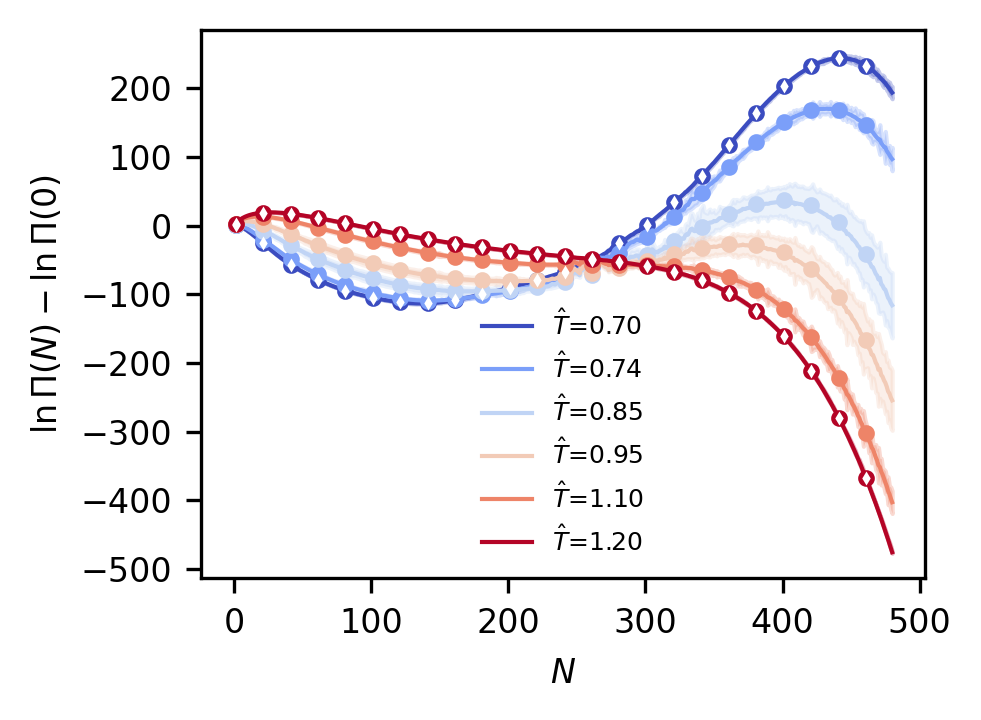

In [10]:
# Set up array of temperatures for which we have data and can compare to our model
test_T = np.array([0.70, 0.74, 0.85, 0.95, 1.10, 1.20])
test_beta = 1.0 / test_T

# Make predictions using the model
gp_mu, gp_var = gp_model.predict_f(
    np.vstack([test_beta, np.zeros_like(test_beta)]).T
)
gp_mu = gp_mu.numpy()
gp_var = gp_var.numpy()
gp_std = np.sqrt(gp_var)

# Add N=0 bin back in, setting it to zero
gp_mu = np.concatenate([np.zeros((gp_mu.shape[0], 1)), gp_mu], axis=-1)
gp_var = np.concatenate([np.zeros((gp_var.shape[0], 1)), gp_var], axis=-1)
gp_std = np.concatenate([np.zeros((gp_std.shape[0], 1)), gp_std], axis=-1)

N_vals = np.arange(gp_mu.shape[1])

tColors = plt.cm.coolwarm(np.linspace(0.0, 1.0, len(test_T)))

fig, ax = plt.subplots(figsize=(3.37, 2.5), dpi=300)

for i in range(len(test_T)):
    
    # Plot predictions at each temperature, both mean and 95% confidence intervals
    this_pred = gp_mu[i, :]
    ax.fill_between(
        N_vals,
        this_pred - 2.0 * gp_std[i, :],
        this_pred + 2.0 * gp_std[i, :],
        color=tColors[i],
        alpha=0.3,
    )
    ax.plot(
        N_vals,
        this_pred,
        linewidth=1.0,
        color=tColors[i],
        label=r"$\hat{T}$=%1.2f" % test_T[i],
    )

    # Plot the reference data at this temperature, adjusting to the same chemical potential
    this_true = np.average(load_lnPi_info(test_T[i], ref_mu=ref_mu)["lnPi"], axis=0)
    ax.plot(N_vals[1::20], this_true[1::20], "o", color=tColors[i], ms=3.0)

# Below loop plots a subset of the data points actually used for training to indicate those temperatures
max_order = int(np.max(gp_model.data[0][:, 1]))
for i in range(len(ref_T)):
    this_ref = gp_model.data[1][i * (max_order + 1), :] * gp_model.scale_fac
    ax.plot(N_vals[1::20], this_ref[::20], "dw", ms=1.0)

ax.tick_params(axis="both", labelsize=8)

ax.legend(fontsize=6, frameon=False)

ax.set_xlabel(r"$N$", fontsize=8)
ax.set_ylabel(r"$\ln \Pi (N) - \ln \Pi (0)$", fontsize=8)

fig.tight_layout()

plt.show()

In [11]:
# Define load_lnPi_info in notebook, use to load lnPi (will need for initial temps and to check at others)
# Reproduce state_from_info_dict, applying to just two temperatures
# Note that cannot use usual active_utils.input_GP_from_state because do not want to include N=0 bin
# With this, define StatelnPi just as simply function to indicate behavior of create_GPR...
# Can just take function that, when called, produces GPR inputs, or State objects
# Create and train GPR model and look at how it does at other temperatures

# To calculate properties from extrapolated GPR models, direct to main text/SI
# Also mention functions in run_LJ_lnPi.py that are based on the tmmc-lnpy package
# Don't want to reproduce all that code... so just say used it and load in data for plotting?
# Could do it on a not-so-fine temperature spacing, like 50 rather than 1000, and do 100 repeats, too
# But it's a lot of code to reproduce and not of great pedagogical value

## Saturation properties

Saturation properties are more difficult to determine based on the macrostate distributions predicted by the GPR model. The reason lies in the assumption that each particle number bin can be treated as independent, only affecting each other in that the same kernel and likelihood model are used and hence the optimal parameters are determined by considering all bins simultaneously. Otherwise, though, the produced probability distribution for $\ln \Pi$ at a new temperature is a produce of independent Gaussians, one for each bin. It turns out this works quite well to capture the temperature dependence, but does not work well when sampling new values. For instance, let's just try sampling two draws from the GPR-predicted distribution at $T_\mathrm{r} = 0.85$ and look at what we get for the macrostate distribution.

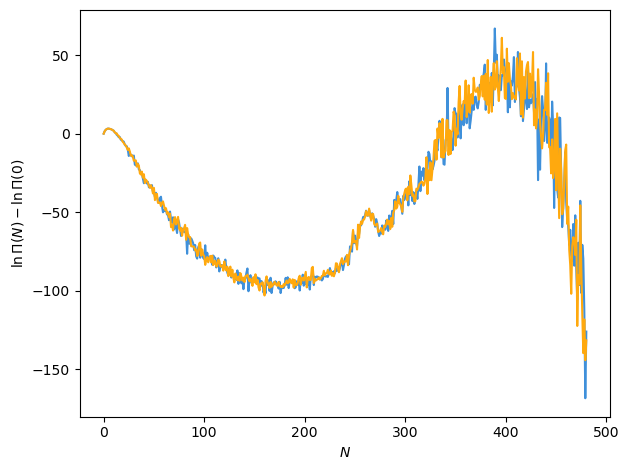

In [12]:
rng = np.random.default_rng()
rand_draw = rng.normal(loc=gp_mu[2, :], scale=gp_std[2, :], size=(2, gp_mu.shape[1]))

fig, ax = plt.subplots()

ax.plot(N_vals, rand_draw.T)

ax.set_xlabel(r"$N$")
ax.set_ylabel(r"$\ln \Pi (N) - \ln \Pi (0)$")

fig.tight_layout()

plt.show()

The problem is that there are clearly correlations between the particle number bins that are not captured when sampling from this distribution. In other words, we've just sampled with a diagonal covariance matrix, effectively, and we would really like to sample with covariances, or non-zero off-diagonal terms. The further we are from reference temperatures used for training, the more noisy the draws will become due to larger uncertainties associated with those GPR predictions.

To remedy this, we can *learn* the correlations in $N$ using a new GP model. Such a model will be simple and easy to train because the prediction from the GPR over temperature exactly specifies the means (output values) and our uncertainty in them (their variances, which will compose a diagonal noise covariance matrix). All we need to learn are the kernel parameters and a we can use a simple likelihood with no optimizable parameters.

In [13]:
# Create data for GP model over N dimension
# No derivatives here, so zeros for second column
x_input = np.vstack(
    [N_vals[1:], np.zeros(N_vals.shape[0] - 1)]
).T
y_input = np.reshape(gp_mu[2, :], (-1, 1))[1:, :]
cov_input = np.diag(np.squeeze(gp_var[2, :])[1:])
# Note that ignoring modeling of N=0 bin... will be zero no matter what, with std of 0
# That can throw off matrix, so ignore for modeling and sampling purposes

# Create model, but make sure to set power scale to zero and constrain it
# Don't want to modify/learn anything about covariance matrix here
particle_bin_gp = active_utils.create_base_GP_model(
    (x_input, y_input, cov_input),
    likelihood_kwargs={
        "p": 0.0,
        "transform_p": None,
        "constrain_p": True,
    },
)

# Train it
active_utils.train_GPR(particle_bin_gp)

And we can take a look at this model...

In [14]:
particle_bin_gp

name,class,transform,prior,trainable,shape,dtype,value
HeteroscedasticGPR.kernel.kernel.var,Parameter,Softplus,,True,(),float64,0.732302
HeteroscedasticGPR.kernel.kernel.l,Parameter,Softplus,,True,(),float64,15.515
HeteroscedasticGPR.likelihood.power_scale,Parameter,Identity,,False,(),float64,0
HeteroscedasticGPR.likelihood.power_add,Parameter,Identity,,False,(),float64,0


Now we can plot the model over the particle number bins with two new draws from it without added noise covariances, seeing that effectively it is smoothly any predictions, adding in correlations between the particle number bins. It turns out, however, that due to the large uncertainty in any of the predicted mean values from the GPR model in temperature, the noise still dominates. This is shown as adding the noise covariance back to the covariance output by the model associated with just the kernel and the correlations over the particle number bins.

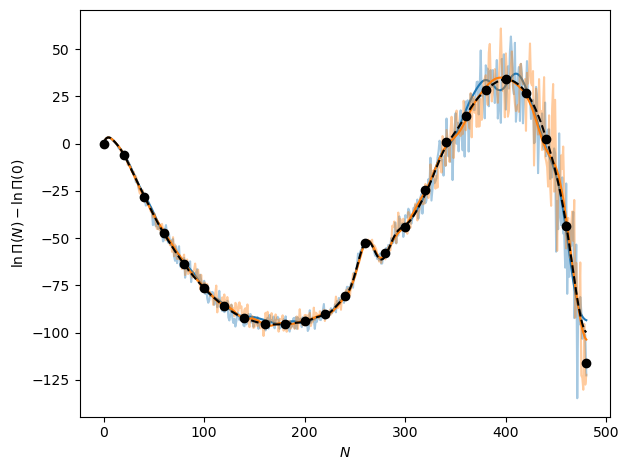

In [15]:
# Want the distribution of functions given the provided inputs
# Evaluating at the input locations, so x=x* and want full covariance
particle_bin_pred = particle_bin_gp.predict_f(particle_bin_gp.data[0], full_cov=True)
particle_bin_mean = particle_bin_pred[0][:, 0].numpy()
# And want uncertainty in model plus noise, so add noise covariance to output
particle_bin_cov = np.squeeze(particle_bin_pred[1]) + cov_input
# But also check what it looks like without noise added back in
particle_bin_cov_no_noise = np.squeeze(particle_bin_pred[1])

# Draw random samples from multivariate normal based on GP output
particle_bin_draw = rng.multivariate_normal(mean=particle_bin_mean, cov=particle_bin_cov, size=2)
particle_bin_draw_no_noise = rng.multivariate_normal(mean=particle_bin_mean, cov=particle_bin_cov_no_noise, size=2)

# Add N=0 bin back in
particle_bin_draw = np.concatenate([np.zeros((2, 1)), particle_bin_draw], axis=-1)
particle_bin_draw_no_noise = np.concatenate([np.zeros((2, 1)), particle_bin_draw_no_noise], axis=-1)

# And plot!
fig, ax = plt.subplots()

for i, color in enumerate(['tab:blue', 'tab:orange']):
    ax.plot(N_vals, particle_bin_draw[i, :], color=color, alpha=0.4)
    ax.plot(N_vals, particle_bin_draw_no_noise[i, :], color=color)

ax.plot(N_vals[1:], particle_bin_mean, 'k--')
ax.plot(N_vals[::20], gp_mu[2, ::20], 'ko')

ax.set_xlabel(r"$N$")
ax.set_ylabel(r"$\ln \Pi (N) - \ln \Pi (0)$")

fig.tight_layout()

plt.show()

Though the noise dominates for this temperature, this will not always be the case and in many cases the learned correlations will in fact be helpful for predicting random changes in a macrostate distribution. At the very least, it is a better probabilistic model for a macrostate distribution, adding in correlations that would not be present in the original prediction from the GPR trained to predict changes with temperature.

Code may be found in `run_LJ_lnPi.py` that performs the model fitting above for each new temperature, takes a large number of random draws, and uses each of those stochastically drawn distributions to compute saturation properties with the tmmc-lnpy package. This creates bootstrapped distributions of saturation properties that can be plotted. The results of this procedure are saved in the file "sat_props_GPR.npz" found in the "SRS_data" directory.

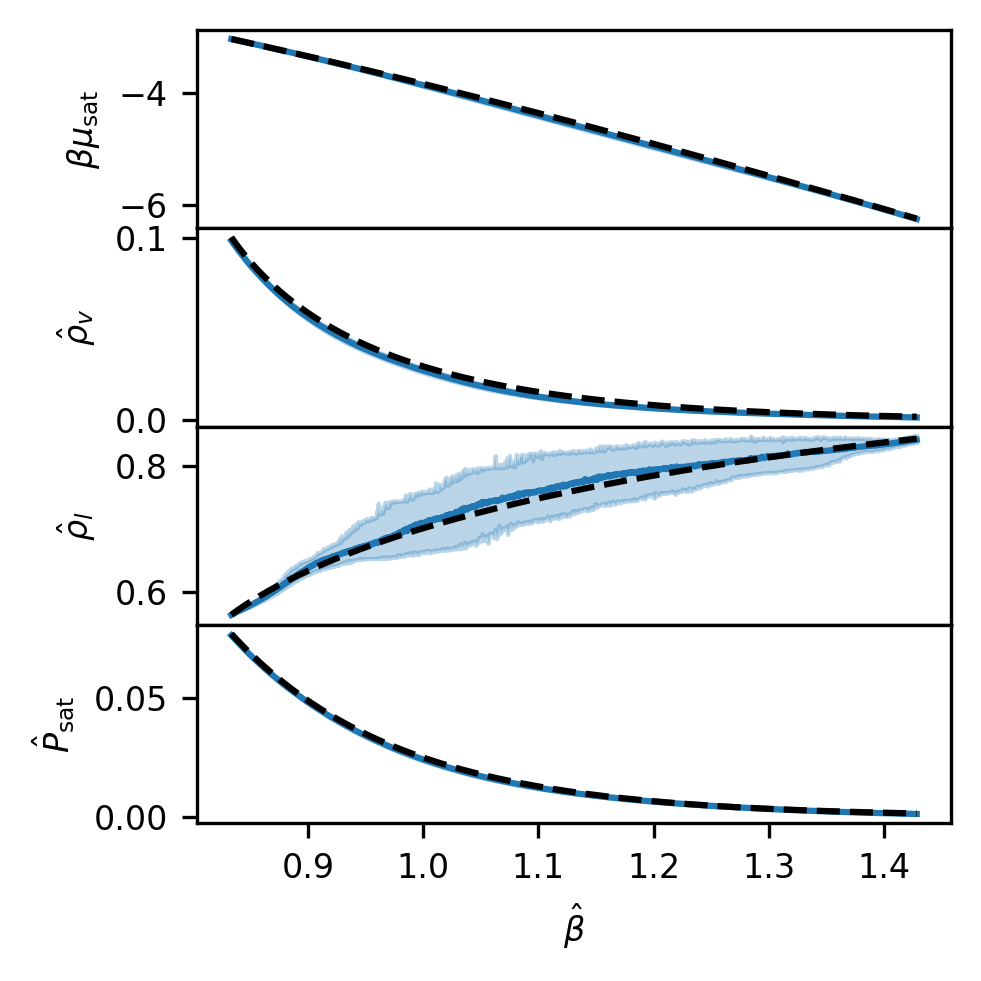

In [16]:
# Load saturation properties
# Should be lnz, density_gas, density_liquid, pressure_gas, pressure_liquid
sat_props = np.load(
    os.path.expanduser("SRS_data/sat_props_GPR.npz")
)
gp_sat_props = sat_props["props"]
gp_sat_props_conf_ints = sat_props["conf_ints"]

# Plot true values versus predicted properties
prop_betas = 1.0 / np.linspace(0.7, 1.2, 1000)

fig, ax = plt.subplots(
    gp_sat_props.shape[1] - 1, sharex=True, sharey=False, figsize=(3.37, 3.37), dpi=300
)

for i, prop in enumerate([raw_lnz, raw_dens[:, 0], raw_dens[:, 1], raw_psat]):
    ax[i].plot(prop_betas, gp_sat_props[:, i], color="tab:blue")
    ax[i].fill_between(
        prop_betas,
        gp_sat_props_conf_ints[:, 0, i],
        gp_sat_props_conf_ints[:, 1, i],
        color="tab:blue",
        alpha=0.3,
    )
    ax[i].plot(raw_beta, prop, "k--")
    ax[i].tick_params(axis="both", labelsize=8)

ax[-1].set_xlabel(r"$\hat{\beta}$", fontsize=8)
ax[0].set_ylabel(r"$\beta \mu_\mathrm{sat}$", fontsize=8)
ax[1].set_ylabel(r"$\hat{\rho}_v$", fontsize=8)
ax[2].set_ylabel(r"$\hat{\rho}_l$", fontsize=8)
ax[3].set_ylabel(r"$\hat{P}_\mathrm{sat}$", fontsize=8)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

This is Figure 10 from our paper.